## GenAI-Powered Data & AI Governance Assistant for a Medical Center's AI Center of Excellence

# NOTE:

**This notebook was developed by Olarinre Salako exclusively for leadership and technical demonstration. The demo is to showcase an unbiased, transparent, approval system for data and AI project in a big medical center that promotes Responsible, Ethical, Accountable, and Legal uses of Data and AI. The demo can be adapted for any organizations in any industry, especially those interested in setting up an AI Center of Excellence. This will protect organizations, employees and patients/clients without stiffling Data & AI innovations.**

# Step 0: Install and Import Modules - Dependencies

These modules will support:
1. PDF text extraction
2. Chunking for RAG
3. FAISS-based vector similarity search
4. GenAI model interfacing (via HuggingFace)


In [ ]:
# !pip install PyPDF2 faiss-cpu langchain openai sentence-transformers transformers
# !pip install accelerate 
# !pip install python-dotenv

In [1]:
# Import modules

from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import pickle
import os
from openai import OpenAI
from my_utils import get_openai_api_key

c:\Users\Dr Olarinre Salako\Desktop\AI_Center_of_Excellence_UTSW_Medical_Center\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 # Step 1: Load, Extract & Chunk the Policy Document.

In [ ]:
# Load the PDF file
pdf_path = "A_Draft_of_AI-Data_Governace_Policy_for_a_Medical Center.pdf"  # Ensure it's in your working directory
reader = PdfReader(pdf_path)

# Extract all text from the PDF
policy_text = "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])

# Split into chunks using LangChain's RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=250)
policy_chunks = text_splitter.split_text(policy_text)


# Step 2: FAISS Indexing

This step will:
1. Convert each chunk into a vector (embedding)
2. Store them in a FAISS index for similarity search during GenAI evaluations

In [ ]:
# Load sentence transformer model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight, efficient

# Generate embeddings for each chunk
embeddings = embedding_model.encode(policy_chunks)

# Create FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

# Save index and metadata for future lookup
faiss.write_index(index, "policy_index.faiss")

with open("policy_chunks.pkl", "wb") as f:
    pickle.dump(policy_chunks, f)


In [ ]:
# Display a few sample chunks and their corresponding embeddings
for i in range(3):
    print(f"\n--- Chunk {i+1} ---")
    print(policy_chunks[i])
    print(f"Embedding shape: {embeddings[i].shape}")
    print(f"Embedding preview (first 10 dims): {embeddings[i][:10]}")

# Step 3: Load a Request and Compare It to the Policy

This step will:
1. Load a request file (e.g. Request_1.txt)
2. Embed it using the same model (all-MiniLM-L6-v2)
3. Query the FAISS index
4. Retrieve top-N most relevant policy chunks

In [ ]:
# Load FAISS index and policy chunks
index = faiss.read_index("policy_index.faiss")
with open("policy_chunks.pkl", "rb") as f:
    policy_chunks = pickle.load(f)

# Load the GenAI request document
with open("Request_1.txt", "r") as file:
    request_text = file.read()

# Embed the request using the same model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
request_embedding = embedding_model.encode([request_text])

# Query FAISS index for top 7 most relevant policy chunks
top_k = 7
distances, indices = index.search(request_embedding, top_k)

In [ ]:
# # Display matched policy sections for review
# print(f"\n Request Summary:\n{request_text[:100]}...\n")
# print(f" Top {top_k} Policy Matches:\n")

# for rank, idx in enumerate(indices[0]):
#     print(f"\n Match #{rank+1}")
#     print(policy_chunks[idx])

# Step 4: Analyze Compliance & Draft a Response Email

This step will:
1. Feed the request and top-5 policy matches to an LLM 
2. Ask the model to: (a) Evaluate compliance. (b) Recommend approval or changes. (c) Generate a professional response email.
3. Email recommend approval or disapproval with reasons:
    1. FROM: Dr. Bill Gates (CDO). 
    2. TO: Requester - the Project Owner.
    3. CC: Dr. Olarinre Salako (Director of AI), with whom the Project Owner will work on the next steps.

NOTE on Model Choice:
1. In this demo, I have used GTP-4, with an OpenAI API Key (you should get one).
2. However, the following free LLMs can be used locally. I just do not want to download the model.

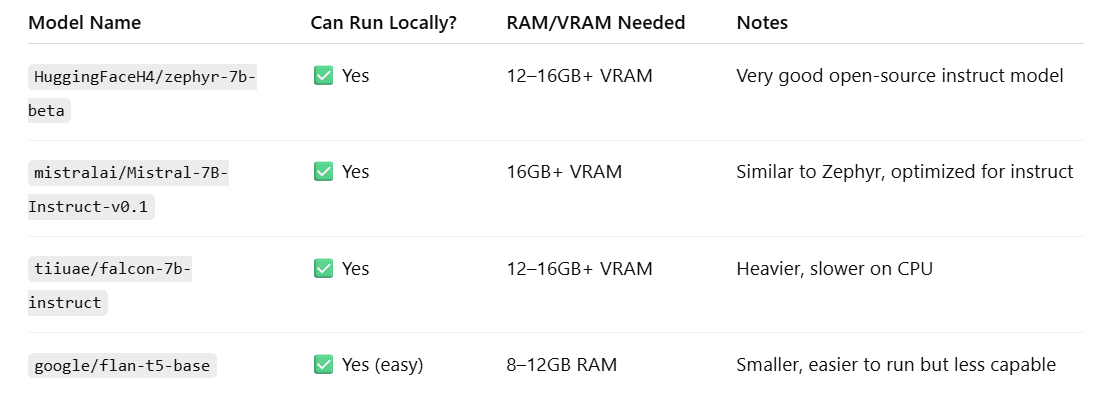

In [ ]:

# Initialize OpenAI client
client = OpenAI(api_key=get_openai_api_key())

# Get all request files in order
request_files = sorted([f for f in os.listdir() if f.startswith("Request_") and f.endswith(".txt")])

for idx, request_file in enumerate(request_files, start=1):
    with open(request_file, "r", encoding="utf-8") as f:
        request_text = f.read()

    # Embed request and get top 5 policy sections
    request_embedding = embedding_model.encode([request_text])
    distances, indices = index.search(request_embedding, 5)
    context = "\n\n".join([policy_chunks[i] for i in indices[0]])

    # Define system role
    system_message = {
        "role": "system",
        "content": (
            "You are a Principal Data & AI Governance Compliance Officer at the Medical Center, "
            "working in the AI Center of Excellence led by Chief Data Officer Dr. Bill Gates. "
            "You are responsible for reviewing AI/Data project requests for compliance with the Medical Center's AI-Data Governance Policy."
        )
    }

    # Few-shot examples
    examples = [
        {
            "role": "user",
            "content": "Project: Uses synthetic data, Tier 3, no PHI. DUA and IRB not required.\n\nPolicy: Internal-only use, SNOMED mapping present, follows CI/CD and privacy audit trail.",
        },
        {
            "role": "assistant",
            "content": (
                "Subject: APPROVED – AI/Data Project Governance Decision\n\n"
                "To: Dr. Emily Zhang, Health Information Management\n"
                "CC: Dr. Dr. Olarinre Salako, Director of AI, AI Center of Excellence\n\n"
                "Dear Dr. Zhang,\n\n"
                "Your AI/Data project request has been reviewed and is fully APPROVED. The proposal complies with Medical Center's governance policy in the following ways:\n"
                "- Risk Tier: Tier 3 – Low Risk (internal NLP tool)\n"
                "- SNOMED and ICD-10 standards applied\n"
                "- Data Type: Synthetic only, no PHI involved\n\n"
                "Next Steps:\n"
                "- Work with Dr. Olarinre Salako to provision the synthetic dataset.\n"
                "- Log the project in the Data Use Registry.\n"
                "- Maintain minimal monitoring as per low-risk classification.\n\n"
                "Thank you for your attention to compliance.\n\n"
                "Sincerely,\nDr. Bill Gates\nChief Data Officer\nAI Center of Excellence\nThe Medical Center"
            )
        },
        {
            "role": "user",
            "content": "Project: Uses real patient data, includes PHI, no DUA or IRB submitted. Public dissemination planned.\n\nPolicy: High-risk, public exposure requires full IRB review and Legal/Comms approval.",
        },
        {
            "role": "assistant",
            "content": (
                "Subject: NOT APPROVED – AI/Data Project Governance Decision\n\n"
                "To: Dr. Ravi Patel, Radiology Department\n"
                "CC: Dr. Olarinre Salako, Director of AI, AI Center of Excellence\n\n"
                "Dear Dr. Patel,\n\n"
                "Following review of your project, it is NOT APPROVED due to the following policy violations:\n"
                "- Use of PHI without IRB approval\n"
                "- No Data Use Agreement (DUA) in place\n"
                "- Public sharing planned without dissemination review\n\n"
                "Next Steps:\n"
                "- Please work with Dr. Olarinre Salako to initiate IRB protocol review\n"
                "- Submit a DUA through the governance committee\n"
                "- Apply de-identification standards before resubmission\n\n"
                "We look forward to supporting your project once these compliance gaps are addressed.\n\n"
                "Sincerely,\nDr. Bill Gates\nChief Data Officer\nAI Center of Excellence\nThe Medical Center."
            )
        }
    ]

    # Construct user prompt
    user_prompt = f"""
    Project Request:
    ----------------------------
    {request_text}
    ----------------------------

    Top 5 Relevant Policy Sections:
    ----------------------------
    {context}
    ----------------------------

    Instructions:
    1. Determine if the request complies with the Medical Center AI-Data Governance Policy.
    2. If NOT compliant:
    - Bulletpoint the violations
    - Recommend corrections
    3. If compliant:
    - Justify approval using governance standards
    4. List actionable “Next Steps” for the Project Owner in collaboration with the Director of AI
    5. Then write a formal email:

    From: Dr. Bill Gates, Chief Data Officer, AI Center of Excellence, The Medical Center  
    To: Project Owner (with Department), The Medical Center 
    CC: Dr. Olarinre Salako, Director of AI, AI Center of Excellence, The Medical Center

    Email must include:
    - Subject: APPROVED or NOT APPROVED – AI/Data Project Governance Decision
    - Greeting, policy reasoning, bulletpoint next steps, and signature.
    Only return the final email body.
    """

    # Run the ChatCompletion with system + few-shot + user messages
    messages = [system_message] + examples + [{"role": "user", "content": user_prompt}]
    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        temperature=0.0,
        max_tokens=2000
    )

    result = response.choices[0].message.content

    # Save to file
    email_filename = f"Decision_Email_{idx}.txt"
    with open(email_filename, "w", encoding="utf-8") as out_f:
        out_f.write(result)

    # Display current result only
    print("\n" + "=" * 100)
    print(f"📩 DECISION EMAIL for {request_file} → saved as {email_filename}")
    print("=" * 100 + "\n")
    print(result)
    print("\n" + "=" * 100 + "\n\n")
